In [1]:
import os
import numpy as np
import librosa
import librosa.display
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
import sounddevice as sd
from tqdm import tqdm  # Importer tqdm pour la barre de progression
from tensorflow.keras import models, layers, initializers
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import soundfile as sf
from datetime import datetime

# Fonction pour générer un spectrogramme
def generate_spectrogram(audio_file, sr=16000, n_mels=128):
    y, sr = librosa.load(audio_file, sr=sr)
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    return log_spectrogram


In [2]:
# Fonction pour afficher et sauvegarder un spectrogramme (optionnel)
def save_spectrogram(log_spectrogram, save_path):
    plt.figure(figsize=(4, 4))
    librosa.display.specshow(log_spectrogram, sr=16000, x_axis='time', y_axis='mel', cmap='viridis')
    plt.axis('off')
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.close()

In [3]:
# Chargement et préparation des données avec spectrogrammes
def load_data_and_generate_spectrograms(folder, label, save_spectrograms=False, output_folder=None):
    dataset = []
    file_list = [f for f in os.listdir(folder) if f.endswith(".wav")]  # Liste des fichiers .wav

    for file_name in tqdm(file_list, desc=f"Traitement des fichiers dans {folder}"):
        file_path = os.path.join(folder, file_name)
        spectrogram = generate_spectrogram(file_path)
        
        # Sauvegarder le spectrogramme sous forme d'image (optionnel)
        if save_spectrograms and output_folder:
            if not os.path.exists(output_folder):
                os.makedirs(output_folder)
            save_path = os.path.join(output_folder, f"{file_name}.png")
            save_spectrogram(spectrogram, save_path)
        
        # Redimensionner à une taille fixe pour le modèle
        spectrogram_resized = cv2.resize(spectrogram, (128, 128))  # Taille fixe (128x128)
        dataset.append((spectrogram_resized, label))
    
    return dataset


In [4]:
# Chemins des dossiers contenant les données
allumer_folder = r"C:/Users/flavi/projet/allumer"
eteindre_folder = r"C:/Users/flavi/projet/eteindre"
inconnu_folder = r"C:/Users/flavi/projet/inconnu"

In [5]:
# Charger et préparer les données avec spectrogrammes
allumer_data = load_data_and_generate_spectrograms(allumer_folder, "allumer")
eteindre_data = load_data_and_generate_spectrograms(eteindre_folder, "eteindre")
inconnu_data = load_data_and_generate_spectrograms(inconnu_folder, "eteindre")
dataset = allumer_data + eteindre_data + inconnu_data


Traitement des fichiers dans C:/Users/flavi/projet/allumer: 100%|████████████████████| 356/356 [00:06<00:00, 52.62it/s]
Traitement des fichiers dans C:/Users/flavi/projet/eteindre: 100%|██████████████████| 319/319 [00:02<00:00, 119.13it/s]
Traitement des fichiers dans C:/Users/flavi/projet/inconnu: 100%|████████████████████| 178/178 [00:01<00:00, 98.11it/s]


In [6]:
# Étape 4 : Préparation des données
# Séparer X (caractéristiques) et y (étiquettes)
X = np.array([data[0] for data in dataset])  # Caractéristiques spectrogrammes
y = np.array([data[1] for data in dataset])  # Étiquettes ("allumer", "eteindre")

# Encoder les étiquettes
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Normalisation des données pour deux cas

## Cas 1 : Pour les CNN, conserver X en 3D
X_cnn = X / 255.0  # Normalisation pour CNN (valeurs entre 0 et 1)

## Cas 2 : Pour d'autres modèles, aplatir X
n_samples, height, width = X.shape
X_flattened = X.reshape(n_samples, -1)  # Convertir en (n_samples, height*width)

# Normalisation des données aplaties
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_flattened)

# Diviser les données en ensembles d'entraînement et de test
# Pour les CNN
X_train_cnn, X_test_cnn, y_train, y_test = train_test_split(X_cnn, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

In [7]:
# Construire le modèle CNN
def build_cnn_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),  # Pour éviter le sur-apprentissage
        layers.Dense(num_classes, activation='softmax')  # Softmax pour les classes
    ])
    
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Forme des données d'entrée
input_shape = (128, 128, 1)  # Hauteur, largeur, canaux (1 pour spectrogrammes en niveaux de gris)
num_classes = len(np.unique(y_encoded))  # Nombre de classes ("allumer", "eteindre", "inconnu")

# Construire le modèle
model = build_cnn_model(input_shape, num_classes)

# Afficher le résumé du modèle
model.summary()

# Configurer l'arrêt précoce
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entraîner le modèle
history = model.fit(
    X_train_cnn, y_train,
    validation_split=0.20,
    epochs=50,
    batch_size=64,
    callbacks=[early_stopping]
)


# Évaluer le modèle sur l'ensemble de test
test_loss, test_accuracy = model.evaluate(X_test_cnn, y_test, verbose=2)
print(f"Loss sur test: {test_loss:.4f}, Accuracy sur test: {test_accuracy:.4f}")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 128)      0

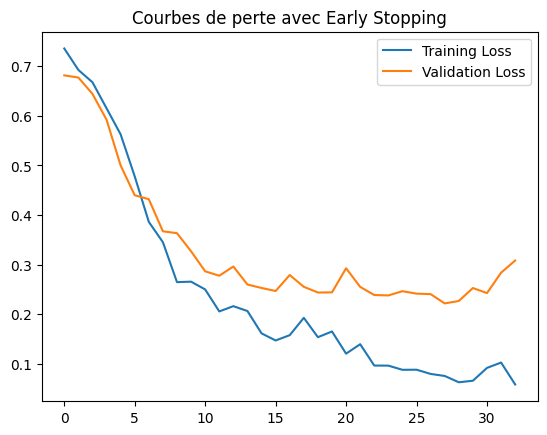

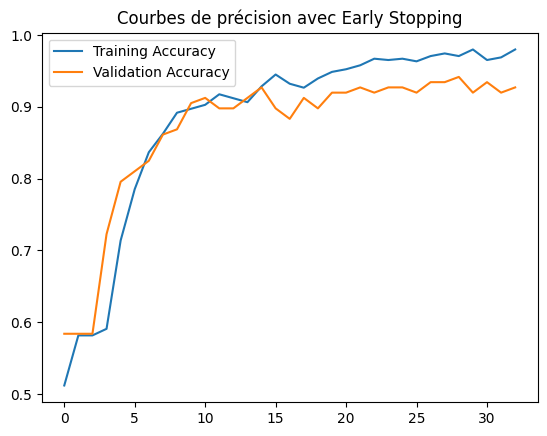

In [8]:
# Tracer les courbes de perte
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Courbes de perte avec Early Stopping')
plt.show()

# Tracer les courbes de précision
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Courbes de précision avec Early Stopping')
plt.show()



6/6 [==============================] - 0s 5ms/step


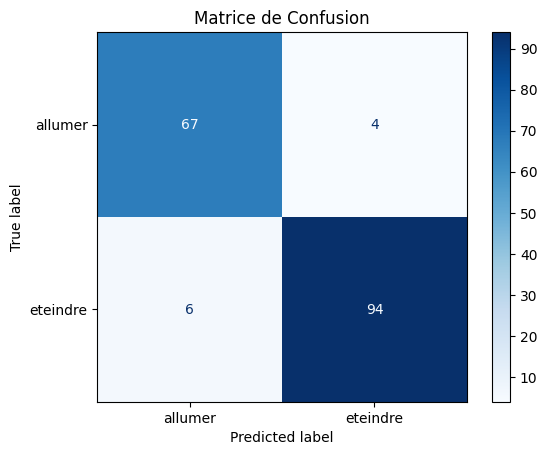

In [9]:
# Matrice de confusion
y_pred = np.argmax(model.predict(X_test_cnn), axis=1)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matrice de Confusion")
plt.show()


In [10]:
def save_audio(audio, sr, folder, base_filename):
    """
    Sauvegarde un fichier audio dans un dossier spécifié avec un nom unique.
    
    Args:
        audio: Les données audio à sauvegarder.
        sr: Fréquence d'échantillonnage.
        folder: Chemin du dossier où sauvegarder l'audio.
        base_filename: Base du nom du fichier audio, comme 'allumer' ou 'eteindre'.
    """
    os.makedirs(folder, exist_ok=True)  # Crée le dossier s'il n'existe pas
    # Générer un nom unique en utilisant l'heure actuelle
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"{base_filename}_{timestamp}.wav"
    filepath = os.path.join(folder, filename)
    sf.write(filepath, audio, sr)
    print(f"Audio sauvegardé dans : {filepath}")


def predict_live_audio_cnn(model, label_encoder, allumer_folder, eteindre_folder, inconnu_folder, sr=16000, duration=1, threshold=0.8):
    """
    Enregistre un audio via le microphone, génère un spectrogramme log-Mel,
    et effectue une prédiction avec un modèle CNN pré-entraîné.
    Permet de sauvegarder l'audio pour enrichir l'entraînement si une erreur est détectée.
    
    Args:
        model: Modèle CNN pré-entraîné (ex. TensorFlow/Keras).
        label_encoder: Encodeur des labels pour décoder les classes.
        allumer_folder: Dossier pour sauvegarder les audios classés comme "allumer".
        eteindre_folder: Dossier pour sauvegarder les audios classés comme "éteindre".
        inconnu_folder: Dossier pour sauvegarder les audios classés comme "inconnu".
        sr: Fréquence d'échantillonnage (par défaut 16 kHz).
        duration: Durée de l'enregistrement (par défaut 1 seconde).
        threshold: Seuil de confiance pour la prédiction (par défaut 0.8).
    """
    try:
        # Étape 1 : Enregistrer un audio via le microphone
        print("Parlez maintenant...")
        audio = sd.rec(int(duration * sr), samplerate=sr, channels=1, dtype='float32')
        sd.wait()
        print("Enregistrement terminé.")
        
        # Étape 2 : Vérifier l'énergie du signal pour ignorer les silences ou bruits faibles
        audio = audio.flatten()
        energy = np.sum(audio**2) / len(audio)
        if energy < 1e-8:
            print("Aucun son détecté (silence ou bruit faible)")
            return

        # Étape 3 : Prétraitement de l'audio
        audio = librosa.util.normalize(audio)  # Normaliser le volume
        if len(audio) < sr * duration:
            padding = sr * duration - len(audio)
            audio = np.pad(audio, (0, padding), mode='constant')
        elif len(audio) > sr * duration:
            audio = audio[:sr * duration]

        # Étape 4 : Générer un spectrogramme log-Mel
        spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128)
        log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)

        # Redimensionner le spectrogramme pour correspondre aux dimensions du modèle CNN
        spectrogram_resized = cv2.resize(log_spectrogram, (128, 128))
        spectrogram_resized = spectrogram_resized / 255.0  # Normalisation
        spectrogram_resized = spectrogram_resized.reshape(1, 128, 128, 1)

        # Étape 5 : Faire la prédiction
        probabilities = model.predict(spectrogram_resized)
        max_prob = probabilities.max()  # Probabilité maximale
        predicted_label = np.argmax(probabilities)

        # Étape 6 : Vérifier si la confiance est suffisante
        if max_prob < threshold:
            print("Mot détecté : Inconnu")
        else:
            predicted_word = label_encoder.inverse_transform([predicted_label])[0]
            print(f"Mot détecté : {predicted_word} (confiance : {max_prob:.2f})")
        
        # Étape 7 : Permettre à l'utilisateur de corriger l'étiquette
        correction = input("La prédiction est-elle correcte ? (oui/non) : ").strip().lower()
        if correction == 'non':
            correct_label = input("Veuillez entrer le mot correct ('allumer', 'eteindre', 'inconnu') : ").strip().lower()
            if correct_label == "allumer":
                save_audio(audio, sr, allumer_folder, "allumer")
            elif correct_label == "eteindre":
                save_audio(audio, sr, eteindre_folder, "eteindre")
            elif correct_label == "inconnu":
                save_audio(audio, sr, inconnu_folder, "inconnu")
            else:
                print("Label incorrect, aucune sauvegarde effectuée.")
        elif correction == 'oui':
            print("Prédiction validée.")
    except Exception as e:
        print(f"Erreur lors de la reconnaissance : {e}")

In [11]:
# Tester la prédiction en temps réel
predict_live_audio_cnn(model, label_encoder, allumer_folder, eteindre_folder,inconnu_folder, sr=16000, duration=2, threshold=0.99)


Parlez maintenant...
Enregistrement terminé.
Aucun son détecté (silence ou bruit faible)
